### Unsupervised Learning on SMS Spam and hap data

##### Understanding the Data

This section gives a basic overview, key characteristics, and any data quality issues.

##### 1. Dataset Overview
- Source: The data is taken from kaggel link- https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset..
- Size: The size of the dataset is (5572, 5).
##### 2. Features
Briefly describe each feature:
| Feature Name     | Data Type    | Description                     |
|------------------|--------------|---------------------------------|
| `v1`      |  Categorical  | repressents weather message is ham or spam|
| `v2`      | Text | represents  the message            
##### 3. Target Variable
- **Name**: category
- **Description**: This variable represents the classification of each message as either 'spam' or 'ham'


In [141]:
#1.1 importing the required libraries
import numpy as np
import pandas as pd

In [142]:
#1.2 load file
dataframe = pd.read_csv('spam.csv', encoding='ISO-8859-1')
dataframe.shape

(5572, 5)

In [143]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


2. Text Procesing
Remove the unwanted columns, missing data, duplicates and renaming the column names

In [144]:
#2.1 Removing the unwanted columns
dataframe.drop(columns={"Unnamed: 2", "Unnamed: 3", "Unnamed: 4"}, inplace=True)

In [145]:
#2.2 Renaming the column names
dataframe.rename(columns={'v1':'category', 'v2':'message'}, inplace=True)

In [146]:
#2.4 Checking for null data
dataframe.isnull().sum()
# dataframe.head(5)

category    0
message     0
dtype: int64

In [147]:
#2.5 Handiling the duplicate data
dataframe.duplicated().sum()
dataframe.drop_duplicates()

,category,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [148]:
#2.6 Encoding the 'ham' and 'spam'
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()

dataframe['category'] = encoder.fit_transform(dataframe['category'])

In [149]:
dataframe['category'].value_counts()

category
0    4825
1     747
Name: count, dtype: int64

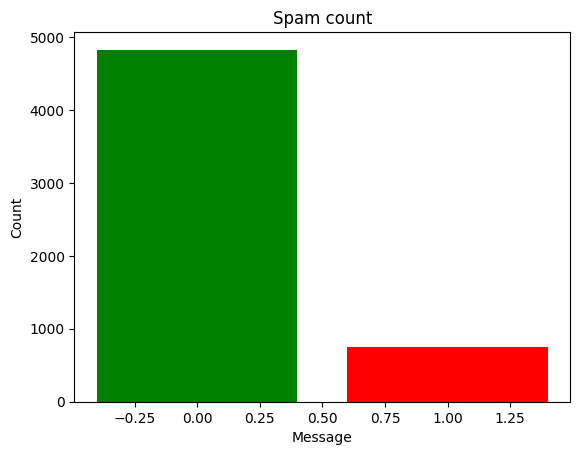

In [150]:
#2.7 visual representation
import matplotlib.pyplot as plt

# Count the frequencies of 'spam' and 'ham'
spam_counts = dataframe['category'].value_counts()

# Create a bar chart
plt.figure(dpi=100)
plt.bar(spam_counts.index, spam_counts.values, color=['green', 'red'])
plt.title("Spam count")
plt.xlabel("Message")
plt.ylabel("Count")
plt.show()

In [151]:

# Function to remove punctuations and stopwords
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
ps = PorterStemmer()

def modify_message(text):
    text = text.lower()
    clearpunc = []
    for char in text:
        if char not in string.punctuation:
            clearpunc.append(char)
    clearpunc = ''.join(clearpunc)

    clearstw = []
    for word in clearpunc.split():
        if word not in stopwords.words('english'):
            clearstw.append(word)
    
    new_text = []
    for word in clearstw:
        new_text.append(ps.stem(word))
    
    return new_text

[nltk_data] Downloading package stopwords to C:\Users\MITI-
[nltk_data]     USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3. Feature Extraction
-Creating and Storing the vector embeddings

In [152]:
#3.1 Creating embeddings using TF-IDF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
tfidf = TfidfVectorizer(max_features=3000, analyzer=modify_message)
embeddings = tfidf.fit_transform(dataframe['message']).toarray()

In [153]:
#3.2 Storing the embeddings  
import pickle as pkl
pkl.dump(embeddings, open("vectorizer.pkl", "wb"))


**Justification for choosing TF-IDF embeddings:**
TF-IDF (Term Frequency-Inverse Document Frequency) is highly suitable for text-based spam filtering because it emphasizes the most relevant terms in a document by down-weighting common words and up-weighting rare but important ones. In the context of spam filtering, TF-IDF helps distinguish between frequent, unimportant words like "the" or "and" and important terms that are more informative in identifying whether an email is spam. By using TF-IDF, the classifier can focus on the words that provide the most meaningful clues for classification, improving accuracy in separating spam from emails.

4. Clustering algorithm selection and implementation

In [165]:
#clustering using k-means 
from sklearn.cluster import KMeans
if np.any(np.isnan(embeddings)):
     raise ValueError("NaN values found in embeddings.")

num_clusters = 600
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
dataframe['cluster'] = kmeans.fit_predict(embeddings)
dataframe.head(5)

,category,message,cluster
0,0,"Go until jurong point, crazy.. Available only ...",106
1,0,Ok lar... Joking wif u oni...,336
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,118
3,0,U dun say so early hor... U c already then say...,173
4,0,"Nah I don't think he goes to usf, he lives aro...",53


**Justification for selecting K-Means:**
K-Means is a great choice for clustering in spam filtering because it's simple and can handle large amounts of data, like many emails. It groups similar emails based on their characteristics, such as word frequency, making it easier to identify spam. Unlike DBSCAN, which has trouble with outliers, and hierarchical clustering, which works best with smaller datasets, K-Means quickly finds clusters and helps us understand the key features of spam emails.

5. Cluster Evaluation and Interpretation:

In [166]:
#metrices used to check the quality of the k-means clusturing
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(embeddings, dataframe['cluster'])
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 1.7530085648560296


In [167]:
from sklearn.metrics import silhouette_score

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(embeddings, dataframe['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.08913398128408329


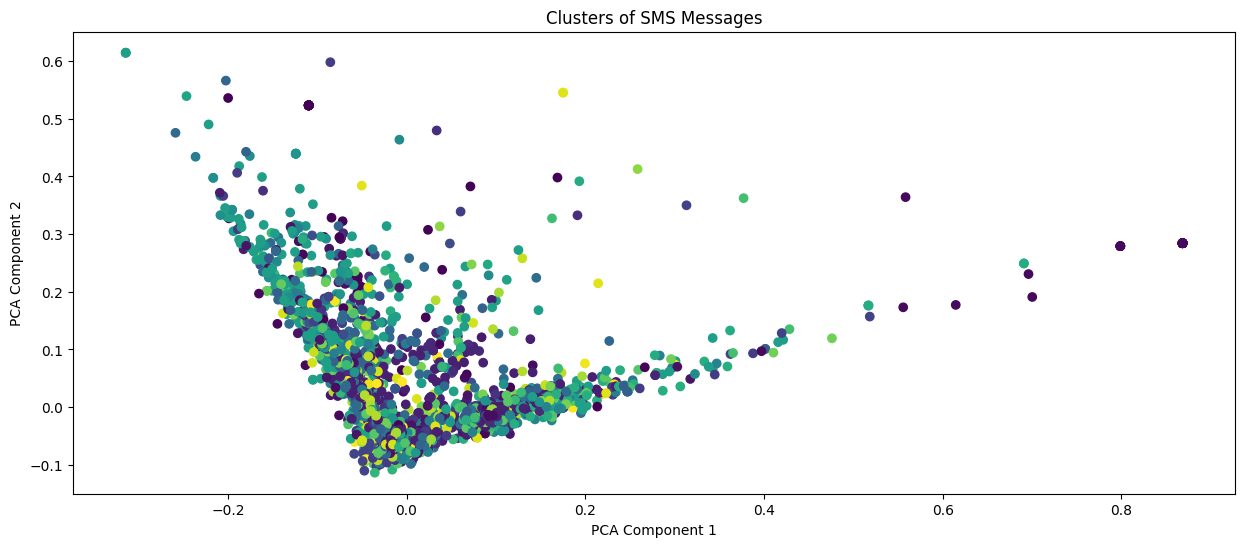

In [168]:
# Visualize the clusters using PCA
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(embeddings)  # Use embeddings for PCA

plt.figure(figsize=(15, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dataframe['cluster'], cmap='viridis')
plt.title('Clusters of SMS Messages')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()